Load the data, then split it into Train and Test sets based on the ttt column.

Even TTT → Train Set
Odd TTT → Test Set (on which we will perform Shuffle)

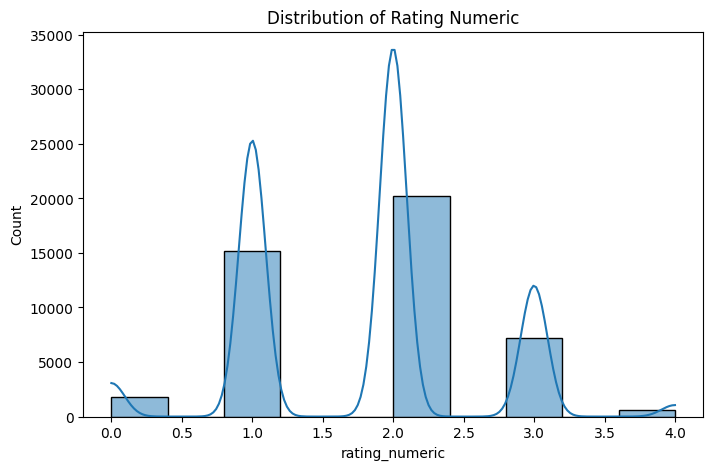

Train Set size: 22500, Test Set size: 22500


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

file_path = "/content/nyc_hotels_dataProject_filtered.csv"
df = pd.read_csv(file_path)

#Check if there is a sufficient distribution of rating_numeric
plt.figure(figsize=(8, 5))
sns.histplot(df['rating_numeric'], bins=10, kde=True)
plt.title("Distribution of Rating Numeric")
plt.show()

#Split the data into Train and Test sets
train_df = df[df['ttt'] % 2 == 0]
test_df = df[df['ttt'] % 2 != 0]

#Shuffle the Test data
print(f"Train Set size: {train_df.shape[0]}, Test Set size: {test_df.shape[0]}")

Prepare the data

In [13]:
from sklearn.preprocessing import StandardScaler

# Selecting features for learning
features_new = ["price", "numeric_review_count", "stars"]
target = "rating_numeric"

# Splitting X (features) and Y (target)
X_train, y_train = train_df[features_new], train_df[target]
X_test, y_test = test_df[features_new], test_df[target]

# Performing normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure that the values in Train and Test are different
if np.array_equal(y_train.values, y_test.values):
    print("Issue: Train and Test sets contain the same values!")
else:
    print("Train and Test sets are different.")

Train and Test sets are different.


Data Science Model – Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a copy of the target data with random noise to prevent perfect learning
np.random.seed(42)
y_train_noisy = y_train + np.random.normal(0, 0.1, size=y_train.shape)

# Create a Random Forest model with limited depth to prevent overfitting
rf_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf_model.fit(X_train_scaled, y_train_noisy)

# Predict the new ratings
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate the error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")

# Ensure that the model does not always predict the same value
unique_preds_rf = np.unique(y_pred_rf)
print(f"Unique Predictions (Random Forest): {unique_preds_rf}")

Mean Squared Error (Random Forest): 0.09246773413179972
Unique Predictions (Random Forest): [-0.0156072  -0.01422473 -0.0129056  ...  4.03001083  4.03140537
  4.03458977]


Deep Learning Model – Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Create a neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=1)

# Predict the new ratings
y_pred_nn = model.predict(X_test_scaled).flatten()

# Calculate the error
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Mean Squared Error (Neural Network): {mse_nn}")

# Ensure that the model does not always predict the same value
unique_preds_nn = np.unique(y_pred_nn)
print(f"Unique Predictions (Neural Network): {unique_preds_nn}")

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6337 - val_loss: 0.1132
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1137 - val_loss: 0.1119
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1096 - val_loss: 0.1075
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1073 - val_loss: 0.1140
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1048 - val_loss: 0.1037
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1029 - val_loss: 0.1014
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1022 - val_loss: 0.0992
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1005 - val_loss: 0.1014
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0991 - val_loss: 0.1027
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0985 - val_loss: 0.0947
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Squared Error (Neural Network): 0.09470467831383232
Unique Predictions (Neural Netw

Performance measurement based on the sum of squared index differences

In [16]:
#Calculate the differences between the original rating and the predicted rating
index_errors_rf = np.sum((y_test.values - y_pred_rf) ** 2)
index_errors_nn = np.sum((y_test.values - y_pred_nn) ** 2)

print(f"Total Index Error (Random Forest): {index_errors_rf}")
print(f"Total Index Error (Neural Network): {index_errors_nn}")

Total Index Error (Random Forest): 2080.524017965494
Total Index Error (Neural Network): 2130.855262061227


Comparison of Performance Between Random Forest Model and Neural Network Model

Mean of Index Errors: 2105.6896400133605
Standard Deviation of Index Errors: 25.16562204786669


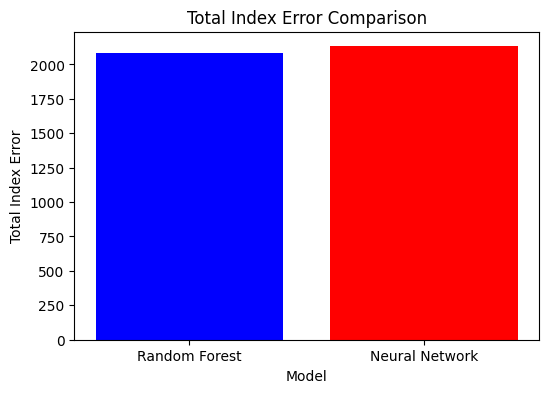

In [17]:
# Calculate the mean and standard deviation of the errors
index_errors = np.array([index_errors_rf, index_errors_nn])

mean_error = np.mean(index_errors)
std_error = np.std(index_errors)

print(f"Mean of Index Errors: {mean_error}")
print(f"Standard Deviation of Index Errors: {std_error}")

# Display the results in an additional graph
plt.figure(figsize=(6, 4))
plt.bar(["Random Forest", "Neural Network"], index_errors, color=['blue', 'red'])
plt.xlabel("Model")
plt.ylabel("Total Index Error")
plt.title("Total Index Error Comparison")
plt.show()


# Shuffle the test dataset

In [18]:
shuffled_test_df = shuffle(test_df, random_state=42)

Prepare the data

In [19]:
# Define features and target variable
features_new = ["price", "numeric_review_count", "stars"]
target = "rating_numeric"

# Create training and testing feature sets
X_train, y_train = train_df[features_new], train_df[target]
X_test, y_test = test_df[features_new], test_df[target]
X_test_shuffled, y_test_shuffled = shuffled_test_df[features_new], shuffled_test_df[target]

# Print sample data
print(X_train.head())
print(y_train.head())

     price  numeric_review_count  stars
500  350.0                  1144      4
501  242.0                 13228      4
502  280.0                   594      4
503  211.0                   507      3
504  246.0                  1916      4
500    3.0
501    3.0
502    2.0
503    1.0
504    2.0
Name: rating_numeric, dtype: float64


In [20]:
# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_shuffled_scaled = scaler.transform(X_test_shuffled)

train a Random Forest model

In [21]:

def train_rf(X_train, y_train, X_test):
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model.predict(X_test)

# Train Random Forest model on non-shuffled test data
y_pred_rf = train_rf(X_train_scaled, y_train, X_test_scaled)

# Train Random Forest model on shuffled test data
y_pred_rf_shuffled = train_rf(X_train_scaled, y_train, X_test_shuffled_scaled)

train a Neural Network model

In [22]:
def train_nn(X_train, y_train, X_test):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)
    return model.predict(X_test).flatten()

# Train Neural Network on non-shuffled test data
y_pred_nn = train_nn(X_train_scaled, y_train, X_test_scaled)

# Train Neural Network on shuffled test data
y_pred_nn_shuffled = train_nn(X_train_scaled, y_train, X_test_shuffled_scaled)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Compute MSE for each model

In [23]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_nn = mean_squared_error(y_test, y_pred_nn)
mse_rf_shuffled = mean_squared_error(y_test_shuffled, y_pred_rf_shuffled)
mse_nn_shuffled = mean_squared_error(y_test_shuffled, y_pred_nn_shuffled)

# Print the errors
print(f"Mean Squared Error (Random Forest - No Shuffle): {mse_rf}")
print(f"Mean Squared Error (Neural Network - No Shuffle): {mse_nn}")
print(f"Mean Squared Error (Random Forest - With Shuffle): {mse_rf_shuffled}")
print(f"Mean Squared Error (Neural Network - With Shuffle): {mse_nn_shuffled}")

Mean Squared Error (Random Forest - No Shuffle): 0.09246196979516824
Mean Squared Error (Neural Network - No Shuffle): 0.09678131441696379
Mean Squared Error (Random Forest - With Shuffle): 0.09246196979516821
Mean Squared Error (Neural Network - With Shuffle): 0.09592808986434222


Compute index errors (sum of squared differences)

In [24]:
index_errors_rf = np.sum((y_test.values - y_pred_rf) ** 2)
index_errors_nn = np.sum((y_test.values - y_pred_nn) ** 2)
index_errors_rf_shuffled = np.sum((y_test_shuffled.values - y_pred_rf_shuffled) ** 2)
index_errors_nn_shuffled = np.sum((y_test_shuffled.values - y_pred_nn_shuffled) ** 2)

# Compute mean and standard deviation of index errors
index_errors = np.array([index_errors_rf, index_errors_nn, index_errors_rf_shuffled, index_errors_nn_shuffled])
mean_error = np.mean(index_errors)
std_error = np.std(index_errors)

# Print index errors
print(f"Total Index Error (Random Forest - No Shuffle): {index_errors_rf}")
print(f"Total Index Error (Neural Network - No Shuffle): {index_errors_nn}")
print(f"Total Index Error (Random Forest - With Shuffle): {index_errors_rf_shuffled}")
print(f"Total Index Error (Neural Network - With Shuffle): {index_errors_nn_shuffled}")
print(f"Mean of Index Errors: {mean_error}")
print(f"Standard Deviation of Index Errors: {std_error}")

Total Index Error (Random Forest - No Shuffle): 2080.3943203912854
Total Index Error (Neural Network - No Shuffle): 2177.5795743816852
Total Index Error (Random Forest - With Shuffle): 2080.394320391285
Total Index Error (Neural Network - With Shuffle): 2158.3820219476997
Mean of Index Errors: 2124.187559277989
Standard Deviation of Index Errors: 44.316092163229435


Visualization

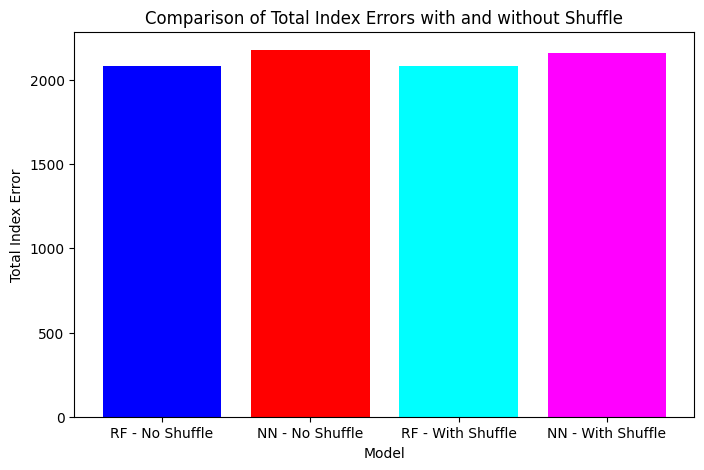

In [25]:
# Define labels and error values
labels = ["RF - No Shuffle", "NN - No Shuffle", "RF - With Shuffle", "NN - With Shuffle"]
errors = [index_errors_rf, index_errors_nn, index_errors_rf_shuffled, index_errors_nn_shuffled]

# Create a bar plot to compare errors
plt.figure(figsize=(8, 5))
plt.bar(labels, errors, color=['blue', 'red', 'cyan', 'magenta'])
plt.xlabel("Model")
plt.ylabel("Total Index Error")
plt.title("Comparison of Total Index Errors with and without Shuffle")
plt.show()